# 88 Soils Example

## [Data and Source](https://qiita.ucsd.edu/study/description/103)

# Import libraries

In [23]:
from __future__ import division

#impute
try:
    from fancyimpute import BiScaler, NuclearNormMinimization, SoftImpute, IterativeSVD, MatrixFactorization
except:
    print("MatrixFactorization not available on this platform, please choose another method.")
    from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, IterativeSVD
    if lr_method=="MatrixFactorization":
        sys.exit('Please choose another method, MatrixFactorization will not run')

#parsing command line
import argparse
import os
#low rank methods (new)
from wpca import WPCA, EMPCA
#pcoa
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from warnings import warn
from scipy.spatial.distance import pdist, squareform
#PCA
from sklearn.decomposition import PCA
#machine leanring
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
#visual
from Impute_vis import PCA_niche
import seaborn as sns
import pylab
import matplotlib
import brewer2mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#other util
import sys
from gneiss.util import match
import scipy
import pandas as pd
import numpy as np
from scipy import stats, optimize
from biom import load_table
import operator
import copy
import warnings

# Define functions

In [24]:
def convert_biom_to_pandas(table): # covert biom
    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,index=table.ids(axis='sample'),columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    for key, value in mapping.items():
        nvalue = ';'.join(value[1:])
        mapping.update({key:nvalue})
    taxonomy = pd.DataFrame(mapping, index=['taxonomy']).T
    return feature_table, taxonomy

def pw_distances(counts, ids=None, metric="braycurtis"):
    
    num_samples = len(counts)
    if ids is not None and num_samples != len(ids):
        raise ValueError("Number of rows in counts must be equal to number of provided ""ids.")
    
    distances = pdist(counts, metric)
    return DistanceMatrix(squareform(distances, force='tomatrix', checks=False), ids)

### Source:

Biom to pandas dataframe code:

Jamie Morton, gneiss, (2016), GitHub repository, https://github.com/biocore/gneiss

# Import Metadata and build classifiers from columns of the data and Import the 88 Soils OTU table

In [25]:


########################### metadata classification ##########################################################
#Mapping import
txlvl=3 #level of taxonomy
mapstart_num=0
mappingdf= pd.read_table('data/soil_map.txt', index_col=0)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
if min(mappingdf.shape)<=1:
    sys.exit('Import error from mapping or metadata (less than two samples or features): please check your metadata is tab delimited format')

############################# import otu information ###################################################
#BIOM
#load table
table = load_table('data/88_soils.biom')
read_filter = lambda val, id_, md: sum(val) > 0
table.filter(read_filter, axis='sample')
table.filter(read_filter, axis='observation')
otu, taxonomy = convert_biom_to_pandas(table)
otu=otu.T
otu=otu.replace(np.nan,0, regex=True)
#add taxa names
taxa_names=list(taxonomy['taxonomy'])

#add unque taxa names for pca/machine leanring (save taxa name for later)
tax_index=[]
otus_index=[]
for q in range(len(otu.index.values)):
    otus_index.append("OTU_%s"%str(q))
otu['new_index']=otus_index
otu = otu.set_index('new_index')

#set taxa names ro level specified by user
if txlvl==42:
    tax_index=otus_index
else:
    for t in taxa_names:
        tax_index.append(";".join(t.split(";")[:txlvl]))


#### match and save data #####

otu, mappingdf = match(otu.T, mappingdf)
otu=otu.T

#remove otus with sum to zero after matching files

otu= otu.loc[(otu.sum(axis=1) != 0)]

# save data, names and classifiers from data frame
index = otu.index.values.tolist()
data = otu.as_matrix()
ids = otu.columns.values.tolist()
ids = list(map(str, ids))

#encode pre preoccessing from mapping

samplenames = mappingdf.index.values.tolist()
samplenames = map(str, samplenames)

encoded_mapping={} #save coded and uncoded as dict
encoded_mappingdf=mappingdf.copy() # encoded dataframe
le = preprocessing.LabelEncoder() # encoder prepreocessing
classifiers_meta=mappingdf.columns.values.tolist() # classifier names
for metatmp in classifiers_meta[mapstart_num:]: # run each classifier
    le.fit(list(set(list(mappingdf[metatmp]))))
    encoded = le.transform(list(mappingdf[metatmp]))
    not_encoded = le.inverse_transform(encoded)
    encoded_mapping[metatmp]=[encoded,not_encoded]
    encoded_mappingdf[metatmp]=encoded #encoded dataframe

#size
print("Number of samples %i"%(int(min(data.shape))))
print("Number of OTUs %i"%(int(max(data.shape))))

Number of samples 89
Number of OTUs 7396



# Supervised Machine Leanring 


<img src="etc/supervised_learning.jpg">



## Machine learning on 16S data is hard due to the low-density and spurious data.

### To overcome this problem we use matrix completion

### Matrix Completion Through Nuclear Norm Minimization 

#### Assume

$M = L_{0} + S_{0}$

$L_{0}$ is a Low-rank matrix

$S_{0}$ is a Sparse spikes noise matrix


Not only can this problem be solved, it can be solved by tractable convex optimization. 


Let $ ||M||_{*} := \sum_{i}σ_{i}(M)$ denote the nuclear norm of the matrix M, 

i.e. the sum of the singular values of M

Let $ ||M||_{1} := \sum_{ij}||M||_{ij}$ denote the 1-norm of M seen as a long vector in R n1×n2

Then it can be shown that the Principal Component Pursuit (PCP) estimate solving


Minimize $ ||L||_{*} + λ||S||_{1}$

Subject to $L + S = M$

It can be shown that this exactly recovers the low-rank $L_{0}$ and the sparse $S_{0}$. Theoretically, this is guaranteed to work even if the rank of $L_{0}$ grows almost linearly in the dimension of the matrix, and the errors in $S_{0}$ are up to a constant fraction of all entries.

#### source


Emmanuel J. Candès , Xiaodong Li , Yi Ma , John Wright, Robust principal component analysis?, Journal of the ACM (JACM), v.58 n.3, p.1-37, May 2011 http://statweb.stanford.edu/~candes/papers/RobustPCA.pdf

Papanicolaou Alex, RPCA, (2011), GitHub repository, https://github.com/apapanico/RPCA


### This allows you to view the underlying trends in the data

<img src="etc/decomp.png">

### Impute the unknown values in the data using SoftImpute from FancyImpute 

##### soft Impute
[softImpute](https://web.stanford.edu/~hastie/swData/softImpute/vignette.html)

##### Fancy Impute
[ Fancy Impute](https://github.com/hammerlab/fancyimpute)


# Unsupervised Machine Leanring 

<img src="etc/supervised_learning.jpg">


### PCA is one commonly used method for feature selection and unsupervised leanring, it's benefits include.

* Standardize the data.
* Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
* Sort eigenvalues in descending order and choose the k eigenvectors that correspond to the k largest eigenvalues where k is the number of dimensions of the new feature subspace (k < d).
* Construct the projection matrix W from the selected k eigenvectors.
* Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.


### Classically PCA cannot be used to determine clustering of data in 16S because PCA is skewed by outliers and can only deal with small I.I.D. Gaussian nosie

<img src="etc/pca_vs_outlier.png">


### To overcome this porblem we use weighted PCA which allows us to deal with the Heteroscedastic Noise


### [WPCA example](https://github.com/jakevdp/wpca/blob/master/WPCA-Example.ipynb)

# Example:
 
###     First we do supervised machine learning on the origonal data 
###      Second we impute the unknown values and do feature selection through WPCA

Then we see the results.

In [26]:
#weight for WPCA
zerow=0
minw=.001
maxw=10000000
component=3
otum=data.T.copy() # make copy for imputation
weight = otum.copy()
for i in range(len(otum)):
    for j in range(len(otum[i])):
        if otum[i][j]==0:
            weight[i][j]=zerow  # weight unknown values as having almost infinite variance (we don't know if they should exist or not) would be infinite if we know we didnt find what did exisit
        else:
            weight[i][j]= (otum[i][j]-minw)/(maxw-minw) # weight low freq otus have having higher possible error and higher frequency as having lower err

#impute
otum=data.copy() # make copy for imputation
otum=otum.astype(np.float64)
#test
otum[otum == 0] = np.nan #make unknown nan
#impute
low_rank_matrix=SoftImpute(max_rank=min(otum.shape),max_iters=200,convergence_threshold=0.000001,min_value=0,max_value=(np.amax(otum)),verbose=False).complete(otum)

In [27]:
#learn origonal data 
X=data.copy()
# split data
X_train, X_test, y_train_all, y_test_all = train_test_split(X.T,np.array(encoded_mappingdf.as_matrix()),test_size=0.2,random_state=0)
sv={} # save scores for each classifier
split_tmp=mapstart_num
for metatmp in classifiers_meta[mapstart_num:]: # run each classifier

    check_tmp=0
    for check_occurance in list(set(encoded_mapping[metatmp][1])):
        if all(isinstance(item, str) for item in encoded_mapping[metatmp][1]) and check_tmp==0:
            if list(encoded_mapping[metatmp][1]).count(check_occurance) <=1:
                check_tmp+=1
                continue

    y_train=y_train_all.T[split_tmp]
    y_test=y_test_all.T[split_tmp]
    split_tmp+=1


    if len(set(encoded_mapping[metatmp][0]))<=1: # can not learn classifiers with one label
        continue

    if len(set(encoded_mapping[metatmp][0]))==2: # if only two possible classifications use support vector classfier
        clfb = svm.SVC(random_state=0)
        clfb.fit(X_train, y_train)
        sv[metatmp] = clfb.score(X_test, y_test)

    if len(set(encoded_mapping[metatmp][0]))>2 and all(isinstance(item, str) for item in encoded_mapping[metatmp][1]): # if not quantity and class is not boolian
        clfm = OneVsOneClassifier(svm.LinearSVC(random_state=0,class_weight="balanced")) # one vs one for imblanced data sets
        clfm.fit(X_train, y_train)
        sv[metatmp] = clfm.score(X_test, y_test)

    else: # if qauntity
        clfr = GridSearchCV(svm.SVR(kernel='rbf',gamma=0.1),cv=5,param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)}, n_jobs=-1) # grid search for optimized perams
        clfr.fit(X_train, y_train)
        sv[metatmp] = clfr.score(X_test, y_test)


#Convert dict to dataframe and choose colors
scores_org = pd.DataFrame(list(sv.items()))
scores_org=scores_org.set_index(scores_org[0])
scores_org = scores_org.drop([0], 1)
scores_org.columns = ['Scores From Original Data']
scores_org.sort_values(['Scores From Original Data'], ascending = [False], inplace = True) 


#learn transformed data 
select_features=True
feature_method="WPCA"
component=3
X=low_rank_matrix.copy()

# feature selection method
if select_features == True:
    if feature_method=="WPCA":
        feature_clf = WPCA(n_components=component)
    else:
        feature_clf = EMPCA(n_components=component)


# split data
X_train, X_test, y_train_all, y_test_all = train_test_split(X.T,np.array(encoded_mappingdf.as_matrix()),test_size=0.2,random_state=0)

#feature selection
if select_features == True:
    weights=X_train.copy()
    for i in range(len(weights)):
        for j in range(len(weights[i])):
            if X_train[i][j]==0:
                weights[i][j]=zerow
            else:
                weights[i][j]= (X_train[i][j]-minw)/(maxw-minw)

    feature_clf.fit(X_train,weights)
    X_t_train = feature_clf.transform(X_train)
    X_t_test = feature_clf.transform(X_test)

#start machine learning

sv={} # save scores for each classifier
split_tmp=mapstart_num
for metatmp in classifiers_meta[mapstart_num:]: # run each classifier

    check_tmp=0
    for check_occurance in list(set(encoded_mapping[metatmp][1])):
        if all(isinstance(item, str) for item in encoded_mapping[metatmp][1]) and check_tmp==0:
            if list(encoded_mapping[metatmp][1]).count(check_occurance) <=1:
                check_tmp+=1
                continue

    y_train=y_train_all.T[split_tmp]
    y_test=y_test_all.T[split_tmp]
    split_tmp+=1

    print("   Running Classifier: %s with %i classes"%(str(metatmp),len(set(encoded_mapping[metatmp][0]))))

    if len(set(encoded_mapping[metatmp][0]))<=1: # can not learn classifiers with one label
        continue

    if len(set(encoded_mapping[metatmp][0]))==2: # if only two possible classifications use support vector classfier

        clfb = svm.SVC(random_state=0)
        clfb.fit(X_t_train, y_train)
        sv[metatmp] = clfb.score(X_t_test, y_test)

    if len(set(encoded_mapping[metatmp][0]))>2 and all(isinstance(item, str) for item in encoded_mapping[metatmp][1]): # if not quantity and class is not boolian

        # feature selection
        clfm = OneVsOneClassifier(svm.LinearSVC(random_state=0,class_weight="balanced")) # one vs one for imblanced data sets
        clfm.fit(X_t_train, y_train)
        sv[metatmp] = clfm.score(X_t_test, y_test)


    else: # if qauntity

        X_t_train = feature_clf.transform(X_train)
        X_t_test = feature_clf.transform(X_test)
        clfr = GridSearchCV(svm.SVR(kernel='rbf'),cv=5,param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)}, n_jobs=-1) # grid search for optimized perams
        clfr.fit(X_t_train, y_train)
        sv[metatmp] = clfr.score(X_t_test, y_test)


#Convert dict to dataframe and choose colors

scores_imputed = pd.DataFrame(list(sv.items()))
scores_imputed=scores_imputed.set_index(scores_imputed[0])
scores_imputed = scores_imputed.drop([0], 1)
scores_imputed.columns = ['Scores From Imputed and Feature Selected Data']
scores_imputed.sort_values(['Scores From Imputed and Feature Selected Data'], ascending = [False], inplace = True) 

   Running Classifier: pH with 77 classes
   Running Classifier: pH_rounded  with 6 classes
   Running Classifier: Annual Season Precipitation with 36 classes
   Running Classifier: Annual Season Tempature with 42 classes
   Running Classifier: Carbon to Nitrogen Ratio with 74 classes
   Running Classifier: Cmin Rate with 88 classes
   Running Classifier: Elevation with 45 classes
   Running Classifier: Latitude with 52 classes
   Running Classifier: Longitude with 52 classes
   Running Classifier: Slit Clay with 51 classes
   Running Classifier: Soil Moisture Deficit with 51 classes
   Running Classifier: Total Organic Carbon with 84 classes
   Running Classifier: Total Organic Nitrogen with 12 classes


# Plot Results 

### Coefficient of determination $ R^2 $ of the prediction.

#### The coefficient $ R^2 $ is defined as $ (1 - u/v) $ , where u is the regression sum of squares $((y_true - y_pred)2).sum() $ and v is the residual sum of squares $ ((y_true - y_true.mean())2).sum() $. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

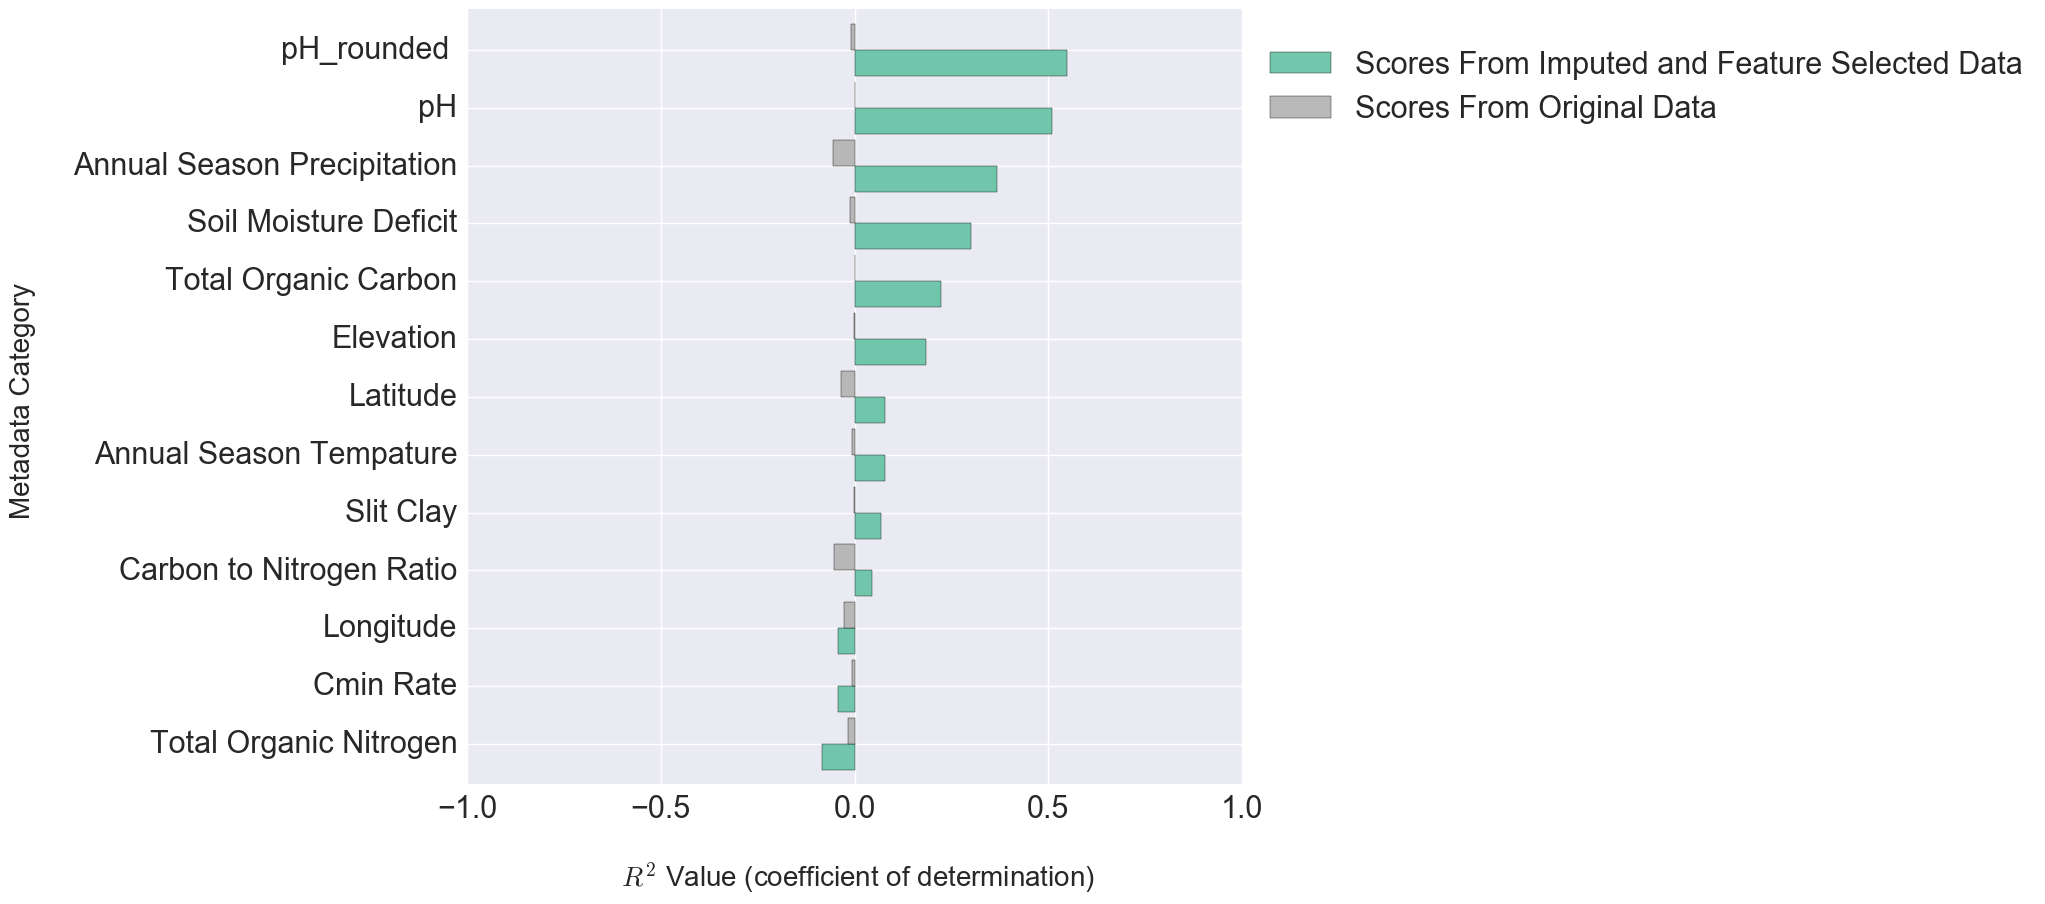

In [28]:
result = pd.concat([scores_imputed, scores_org], axis=1, join='inner')
result.sort_values(['Scores From Imputed and Feature Selected Data'], ascending = [True], inplace = True)
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
result.plot(kind="barh",xlim=(-1,1),colormap="Set2",width=.9,alpha = 0.92,fontsize=22,ax=ax1)
ax1.legend(loc='center left', bbox_to_anchor=(1, .9),prop={'size':22})
#ax1.set_axis_bgcolor('white')
ax1.set_ylabel("Metadata Category \n",{'size':'20'})
ax1.set_xlabel("\n $R^2$ Value (coefficient of determination)",{'size':'20'})
plt.show()

 ##  As you can see the results show that the Imputed data allows for much more acctuate machine leanring 

# Extracting biological knowledge through WPCA and Matrix Completion

### What is PCoA

* It is similar in spirit to PCA but it takes a dissimilarity as input! A dissimilarity matrix shows the distance between every possible pair of objects.

* Is a set of data analysis techniques that display the structure of (complex) distance-like data (a dissimilarity matrix!) in a high dimensional space into a lower dimensional space without too much loss of information.

* The goal of MDS is to faithfully represent these distances with the lowest possible dimensional space.

http://www.sequentix.de/gelquest/help/principal_coordinates_analysis.htm

### Why would you use PCA in 16S analysis 

* Dimensionality Reduction and visualization in 3D

16S rRNA analysis begins by processing raw sequencing reads into a matrix called and OTU table that is high dimensional and by using PCA the data can be visualized in 3 dimensions or less.

* Extract what bacteria are cauing variance between samples directly from PCA visualization 

From PCA graphs you can view which bacteria are contributing most to the changes along an axis in your graph. This means unlike the conventional PCoA, in PCA your axis has meaning!


# Example:

# Recovering information about features from PCA eigenvectors  


### Suppose we would like to see how the bacteria chnage along this first axis of pH since our machine leanring identified that as the best catagory from the metadata.

### If the gradient change is along that axis we can then say what bacteria chnages the most along that axis.

### The priniple components are a linear combination of origonal features in N dimentional space

### $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

#### Where $\beta_{N}^{j}$ are wieghts and $X_{N}$ is the origonal variables

#### Therefore the coefficients are the transfrom of an idenity matrix of shape X

#### Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weights pertaining to each principal component $ PC^{j}$. 

#### In other words we can examine the weights on each OTU or bacteria that best explain the variance of each axis in our PCA graph. 

/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/pandas/indexes/multi.py:610: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_value(s, k)
/Users/cameronmartino/anaconda/envs/DEICODE_env/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


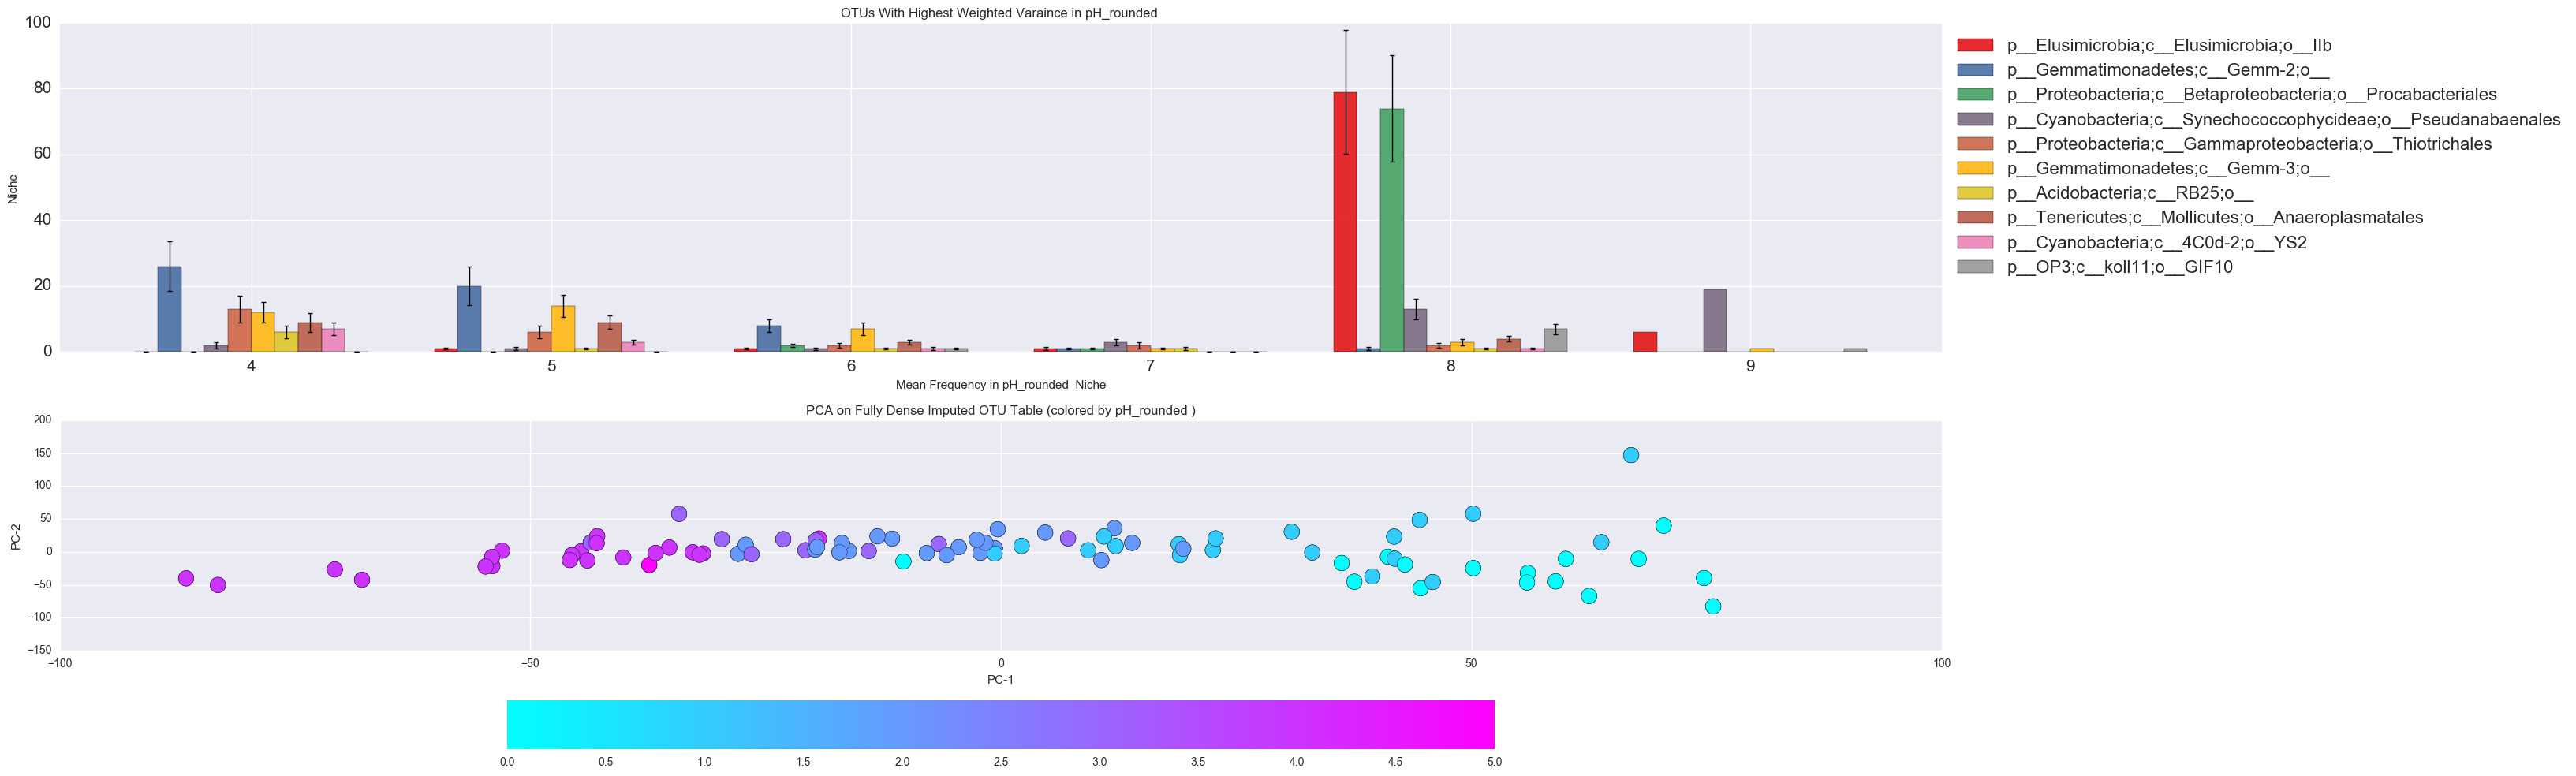

In [31]:
# View bacteria causing variance on the first axis
bact_to_show=10 # number of bacteria to extract
niche_plot='pH_rounded ' # any column from mapping
Pc_plot="PC-1" # can be PC-2
imputed_in=low_rank_matrix.copy() # imputed data to use
cont=True # default true, false if not continous data
# Extract information from imputed PCA axis  
out_niche_linkeddf,observed_table_sfi,index_mean,index_std,highest_var_bact,pccompdf  = PCA_niche.niche_visual(otu,imputed_in,tax_index,bact_to_show,niche_plot,Pc_plot,mappingdf,weight)
# Visualize the data
plt = PCA_niche.plot_niche(out_niche_linkeddf,observed_table_sfi,mappingdf,encoded_mapping,niche_plot,Pc_plot,index_mean,index_std,le,cont,weight)
plt.show()

## The Bacteria with the highest variance between pH clusters by multivariate weights make sense because they belong to the families Bradyrhizobiaceae, Sinobacteraceae and Acidobacteriaceae. All of which have members that are described to grow at pH as low as 3 (B. elkanii (Jordan, 1982) and A. capsulatum (Hrash and Coates, 2011)), and pH 5 (S. flavus (Zhou et al., 2008)).

# This not only matches the papers conclustions where this data came from 

http://aem.asm.org/content/75/15/5111.full

# It also makes Biological sense



In [126]:
plt.close('all')